# Load Data
The primary data source is the spreadsheet data file from the presentation organization portal. It is also possible to load the data after it has been separated into oral and poster dataframes.

The abstracts were initially collected for session organization and not for public publication. This Jupyter notebook displays the steps used to create embeddings from the presentation titles and abstracts. However, since the orginal data is not available for inclusion in this repository, this notebook also enables loading the presentation data without the abstracts. This includes the presentation data and the embeddings created from those abstracts. Loading the embeddings also enables much quicker processing and data exploration as the embeddings take many minutes to calculate.

## Primary Data Source

In [1]:
import pandas as pd

df = pd.read_excel("1.29.25 Abstracts.xlsx")
df = df.rename(columns={'Session':'Original Session',
                        'Submission Name':'Title',
                        'Abstract-Character max 4000-Abstracts will only be used to evaluate quality of talk and topic. They will not be published or able to be edited later.':'Abstract',
                        'Submission ID - 7 digits':'Abstract ID',
                        'Technical Community':'Original Technical Community',
                        'Profile: First Name':'First Name',
                        'Profile: Last Name':'Last Name',
                        })


In [2]:
# Drop any presentations that are missing an abstrct or title
df.dropna(subset=['Title','Abstract'], inplace=True)

In [3]:
import pandas as pd

# Before beginning, make sure all presentations have a session assigned. Unassigned presentations are given the session name, unassigned.

df['Original Session'] = df['Original Session'].fillna('UNASSIGNED')

In [4]:
# Combine Titles and Abstracts with a semicolon in between. This should be the same as + but .agg() handles empty fields or fields that have non-text entries.
df['Title and Abstract'] = df[['Title', 'Abstract',]].agg(': '.join, axis=1)
print(f"Title and Abstract: \n{df['Title and Abstract'].head()}")

Title and Abstract: 
0    Repurposing of low-value biomass into engineer...
1    AI Tools and Text Embedding for Session Organi...
2    Automatic ASABE AIM Session Creation using Mac...
3    Soil and Wastewater Effluent Properties of Oil...
4    MODELLING GULLIES FORMED FROM RILLS : An exper...
Name: Title and Abstract, dtype: object


In [5]:
# Select the oral presentations only
oral_df = df[~df['Original Session'].str.contains('POSTER', case=False, na=False)].copy()

### Save dataframes for accessing without the spreadsheet.

In [6]:
import pickle
with open('df_doc.pkl', 'wb') as file:
    pickle.dump(df, file)
with open('oral_df_doc.pkl', 'wb') as file:
    pickle.dump(oral_df, file)


## Create Embeddings and Similarities
### Model: cde-small-v1

In [7]:
from sentence_transformers import SentenceTransformer
# Line below should be uncommented to run. It must be commented out for Git commit as its output is interpreted as containing a secret. 
cde_embeddings_model = SentenceTransformer('jxm/cde-small-v1', trust_remote_code=True)
print("Model Card:\n", cde_embeddings_model.model_card_data)
print("Similarity Function (None defaults to cosine): ", cde_embeddings_model.similarity_fn_name)
print("Max Token Length:", cde_embeddings_model.tokenizer.model_max_length)

c:\py-venvs\text_sort\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\py-venvs\text_sort\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jdv223\.cache\huggingface\hub\models--jxm--cde-small-v1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: ht

Model Card:
 tags:
- sentence-transformers
- sentence-similarity
- feature-extraction
base_model: jxm/cde-small-v1
pipeline_tag: sentence-similarity
library_name: sentence-transformers
Similarity Function (None defaults to cosine):  cosine
Max Token Length: 8192


In [8]:
# Text to embed
doc_topics = oral_df['Title and Abstract'].tolist()

Tokenizer maximum sequence length: 8192


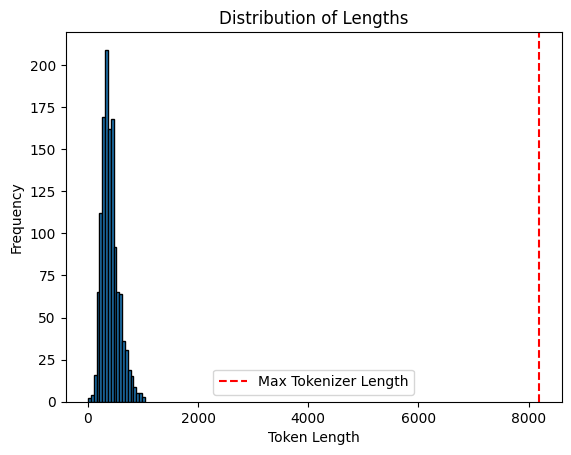

In [9]:
cde_tokenizer = cde_embeddings_model.tokenizer
cde_max_length = cde_tokenizer.model_max_length
print(f"Tokenizer maximum sequence length: {cde_max_length}")
cde_tokenized_lengths = [len(cde_tokenizer.tokenize(text)) for text in doc_topics]
cde_token_out = [cde_tokenizer.tokenize(text, truncation=True, max_length=cde_max_length) for text in doc_topics]
cde_concatenated_output = [" ".join(tokens) for tokens in cde_token_out]  # List of strings

import matplotlib.pyplot as plt
# Plot length  distribution
plt.hist(cde_tokenized_lengths, bins=20, edgecolor='black')
plt.axvline(x=cde_max_length, color='r',
            linestyle='--', label='Max Tokenizer Length')
plt.title('Distribution of Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Embed Presentations

Create the dataset embeddings as required by this model.

In [10]:
import time
import random

minicorpus_size = cde_embeddings_model[0].config.transductive_corpus_size
# Get the unique elements from the original population
#    Using list(set(...)) ensures uniqueness and handles potential duplicates in doc_topics
unique_docs = list(set(doc_topics))
num_unique = len(unique_docs)
if minicorpus_size < num_unique:
    # Put some strings here that are representative of your corpus, for example by calling random.sample(corpus, k=minicorpus_size)
    minicorpus_docs = random.sample(doc_topics, k=minicorpus_size)
else: 
    # Start the minicorpus with all unique documents
    minicorpus_docs = list(unique_docs) # Make a copy to start

    # Calculate how many more documents are needed
    remaining_needed = minicorpus_size - num_unique

    # If more are needed, sample *with replacement* from the *original* population
    if remaining_needed > 0:
        # Sample the remaining items randomly WITH replacement from the original doc_topics
        additional_docs = random.choices(doc_topics, k=remaining_needed)
        # Add these to the minicorpus
        minicorpus_docs.extend(additional_docs)
assert len(minicorpus_docs) == minicorpus_size # You must use exactly this many documents in the minicorpus. You can oversample if your corpus is smaller.


start_time = time.time()
cde_dataset_embeddings = cde_embeddings_model.encode(
    minicorpus_docs,
    prompt_name="document",
    convert_to_tensor=True
)
end_time = time.time()
cde_dataset_elapsed_time = end_time - start_time
print(f"Titles Embedded: {len(cde_dataset_embeddings)}, Length of Vectors: {len(cde_dataset_embeddings[0])}")
print(f"Dataset Encoding time: {cde_dataset_elapsed_time:.4f} seconds")

Titles Embedded: 512, Length of Vectors: 768
Dataset Encoding time: 21.5900 seconds


Then perform the main embedding

In [11]:
start_time = time.time()
cde_doc_embeddings = cde_embeddings_model.encode(
    doc_topics,
    prompt_name="document",
    dataset_embeddings=cde_dataset_embeddings,
    convert_to_tensor=True,
)
end_time = time.time()
cde_doc_elapsed_time = end_time - start_time
print(f"Titles Embedded: {len(cde_doc_embeddings)}, Length of Vectors: {len(cde_doc_embeddings[0])}")
print(f"Document Encoding time: {cde_doc_elapsed_time:.4f} seconds")
cde_elapsed_time = cde_doc_elapsed_time+cde_dataset_elapsed_time
print(f"Total Encoding time: {(cde_elapsed_time):.4f} seconds")

Titles Embedded: 1251, Length of Vectors: 768
Document Encoding time: 577.7313 seconds
Total Encoding time: 599.3213 seconds


In [12]:
cde_similarities = cde_embeddings_model.similarity(cde_doc_embeddings, cde_doc_embeddings)
# Convert similarity matrix to a dataframe (will use dataframe as it is easier to drop index values)
oral_similarities_df = pd.DataFrame(cde_similarities.cpu(), index = oral_df.index, columns=oral_df.index)
oral_embeddings_df = pd.DataFrame(cde_doc_embeddings.cpu(), index = oral_df.index)

Save the similarities as a dataframe and as a tensor pickle

In [13]:
import torch
oral_similarities_df.to_pickle('AIM2025_similarities.pkl')
oral_embeddings_df.to_pickle('AIM2025_embeddings.pkl')
torch.save(cde_doc_embeddings, 'AIM2025_embeddings.pt')
torch.save(cde_similarities, 'AIM2025_similarities.pt')

## Load Data
This enables starting at this point without re-embedding the presentations.
Code can be commented out to skip.

In [14]:
import pickle
import torch
import pandas as pd

# For loading base oral dataframe:
with open('df_doc.pkl', 'rb') as file:
    df = pickle.load(file)
with open('oral_df_doc.pkl', 'rb') as file:
    oral_df = pickle.load(file)
doc_topics = oral_df['Title and Abstract'].tolist()

# Load the similarity matrices (will use dataframe as it is easier to manage)
# cde_similarities = torch.load('aim2025_embeddings.pt', weights_only=False)
oral_similarities_df = pd.read_pickle('AIM2025_similarities.pkl')
oral_embeddings_df = pd.read_pickle('AIM2025_embeddings.pkl')

## Create Dataframes
Presentations and the associated Similarity matrices need matching indices.

Find duplicates or nearly identical presentations. Some presentations appear to have been resubmissions to correct typos. They are not strictly duplicates, but should not be considered any further. They would be removed in manual sorting anyhow.

In [15]:
import pandas as pd
import numpy as np

# --- Ensure indices are aligned across these three dataframes ---

print(f"Original number of oral presentations: {len(oral_df)}")
print(f"Original shape of similarities matrix: {oral_similarities_df.shape}")
print(f"Original shape of embeddings matrix: {oral_embeddings_df.shape}")

# Define the similarity threshold for considering items as near duplicates
# Difference < 0.01 means Similarity >= 0.99
similarity_threshold = 0.99

# Get the indices from the dataframe (important for referencing)
presentation_indices = oral_similarities_df.index.tolist()
index_map = {i: idx for i, idx in enumerate(presentation_indices)} # Map position to actual index

# Create a set to store the indices we want to REMOVE
indices_to_remove = set()

# Iterate through the upper triangle of the similarity matrix to avoid redundant checks and self-comparison
# Use iloc for positional indexing which is often faster for loops
similarity_matrix_np = oral_similarities_df.values # Get numpy array for faster access
num_items = similarity_matrix_np.shape[0]

for i in range(num_items):
    for j in range(i + 1, num_items): # Start j from i+1 to get upper triangle
        similarity_score = similarity_matrix_np[i, j]

        if similarity_score >= similarity_threshold:
            # Found a near-duplicate pair
            index_i = index_map[i] # Get the actual index value
            index_j = index_map[j] # Get the actual index value

            # Identify the index to remove (the one with the lower value)
            index_to_drop = min(index_i, index_j)
            index_to_keep = max(index_i, index_j)

            # Add the lower index to the set for removal
            indices_to_remove.add(index_to_drop)
            # Optional: print information about the identified pair
            # print(f"Near duplicate found: Index {index_i} and Index {index_j} (Similarity: {similarity_score:.4f}). Keeping {index_to_keep}, removing {index_to_drop}.")


# Convert the set of indices to remove into a list
indices_to_remove_list = sorted(list(indices_to_remove)) # Sorting is optional but good practice

print(f"\nFound {len(indices_to_remove_list)} near-duplicate presentations to remove (keeping highest index).")
print(f"Indices to remove: {indices_to_remove_list}")

# --- Perform the removal ---

# Keep only the rows whose indices are NOT in the removal list
oral_df = oral_df.drop(index=indices_to_remove_list)
oral_embeddings_df = oral_embeddings_df.drop(index=indices_to_remove_list)

# For the square similarity matrix, remove both rows and columns
oral_similarities_df = oral_similarities_df.drop(index=indices_to_remove_list, columns=indices_to_remove_list)

# --- Verification ---
print(f"\nFinal number of oral presentations: {len(oral_df)}")
print(f"Final shape of similarities matrix: {oral_similarities_df.shape}")
print(f"Final shape of embeddings matrix: {oral_embeddings_df.shape}")

# Verify indices still match
if not oral_df.index.equals(oral_embeddings_df.index):
     print("Warning: Indices of oral_df and oral_embeddings_df do not match!")
if not oral_df.index.equals(oral_similarities_df.index):
     print("Warning: Row indices of oral_df and oral_similarities_df do not match!")
if not oral_similarities_df.index.equals(oral_similarities_df.columns):
     print("Warning: Row and Column indices of oral_similarities_df do not match!")

# You can now use oral_df, oral_embeddings_df, and oral_similarities_df

Original number of oral presentations: 1251
Original shape of similarities matrix: (1251, 1251)
Original shape of embeddings matrix: (1251, 768)

Found 12 near-duplicate presentations to remove (keeping highest index).
Indices to remove: [77, 221, 223, 497, 762, 999, 1027, 1147, 1179, 1201, 1509, 1527]

Final number of oral presentations: 1239
Final shape of similarities matrix: (1239, 1239)
Final shape of embeddings matrix: (1239, 768)


In [16]:
# Check for duplicate rows based on all columns
duplicates_check = oral_df.duplicated(subset=['Title and Abstract'])

# See which rows are marked as duplicates
print(oral_df[duplicates_check])

Empty DataFrame
Columns: [Original Session, Title, Abstract, Abstract ID, Original Technical Community, First Name, Last Name, Title and Abstract]
Index: []


In [17]:
# Check to make sure indicies are the same
all(oral_df.index == oral_similarities_df.index)

True

Since the dataframes that are being processed are selections from other dataframes, not all indices are present. Reset indices for the presentations and the similarity dataframes. Then convert the similarity dataframes to numpy arrays and tensors for processing. The array indices for the similarity numpy arrays match the row indices for the presentation dataframe.

In [18]:
oral_df = oral_df.reset_index()
oral_similarities_df.reset_index(drop=True, inplace=True)
oral_embeddings_df.reset_index(drop=True, inplace=True)
# Convert the similarities DataFrame to a NumPy array (this will drop/reset the index and columns)
oral_similarities_np = oral_similarities_df.values
# Convert the NumPy array to a PyTorch tensor
oral_similarities_tensor = torch.tensor(oral_similarities_np, dtype=torch.float32)

### Save the reindexed dataframe for use in a data exploration app.

In [19]:
oral_similarities_app_df = pd.DataFrame(oral_similarities_tensor.cpu(), index = oral_df.index, columns=oral_df.index)
oral_similarities_app_df.to_pickle('oral_app_similarities.pkl')
oral_embeddings_df.to_pickle('oral_app_embeddings.pkl')

# Session Analysis Functions

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import torch  # Make sure torch is imported

def analyze_sessions(sessions, similarities):
    """
    Calculates statistics and generates plots for a list of sessions.

    Args:
        sessions (list of lists):  Each inner list contains the indices of presentations in a session.
        similarities (torch.Tensor):  The cosine similarity matrix.

    Returns:
        dict: A dictionary containing the calculated statistics.
    """

    num_sessions = len(sessions)
    session_similarities = []
    session_sizes = []
    clusters_gt1 = 0

    for session in sessions:
        session_sizes.append(len(session))
        if len(session) > 1:
            clusters_gt1 += 1
            session_tensor = torch.tensor(session)
            session_similarity_matrix = similarities[session_tensor, :][:, session_tensor]
            #Exclude diagonal values
            similarity_sum = 0
            for i in range(len(session)):
              for j in range(i + 1, len(session)):
                similarity_sum += session_similarity_matrix[i, j].item()

            avg_session_similarity = similarity_sum / (len(session) * (len(session) - 1) / 2) if (len(session) * (len(session) - 1) / 2) > 0 else 0.0
            session_similarities.append(avg_session_similarity)
        elif len(session) == 1:
          session_similarities.append(0.0) #Similarity is not meaningful for one item
        else:
          session_similarities.append(0.0) #empty session


    overall_avg_similarity = np.mean(session_similarities) if session_similarities else 0.0 #Handles the case if all sessions have one element
    min_session_similarity = min(session_similarities) if session_similarities else 0.0  # Handle empty case

    # Create a dictionary to store cluster sizes and their frequencies (for plotting)
    size_counts = {}
    for size in session_sizes:
        size_counts[size] = size_counts.get(size, 0) + 1

    # Create a dictionary to store cluster similarities and frequencies.  Not really frequencies, but a list of values.
    similarity_values = {}
    for i, sim in enumerate(session_similarities):
        similarity_values[i] = sim  # Store with session index as key

    results = {
        'avg_similarity': overall_avg_similarity,
        'min_session_similarity': min_session_similarity,
        'num_sessions': num_sessions,
        'clusters_gt1': clusters_gt1,
        'size_counts': size_counts,
        'similarity_values': similarity_values,
        'session_similarities' : session_similarities
    }
    return results

In [21]:
# These functions are used to build cluster lists and calculate cluster similarities from the original dataframes for analysis and plotting.
# The analysis functions expect this format as they were designed to work with the output from the clustering algorithms.
import numpy as np
import pandas as pd

def calculate_cluster_similarities(similarity_matrix, labels):
    """
    Calculate average similarity of each document with others in its cluster
    
    Returns:
    - document_similarities: Average similarity of each document with its cluster
    - cluster_avg_similarities: Average similarity for each cluster
    """
    n_samples = len(labels)
    document_similarities = np.zeros(n_samples)
    cluster_avg_similarities = {}
    
    for i in range(n_samples):
        # Get indices of other documents in the same cluster
        cluster_idx = np.where(labels == labels[i])[0]
        cluster_idx = cluster_idx[cluster_idx != i]  # Exclude self
        
        if len(cluster_idx) > 0:  # If there are other documents in the cluster
            # Calculate average similarity with other documents in cluster
            document_similarities[i] = np.mean(similarity_matrix[i, cluster_idx])
        
    # Calculate average similarity for each cluster
    unique_clusters = np.unique(labels)
    for cluster in unique_clusters:
        cluster_mask = labels == cluster
        cluster_docs = np.where(cluster_mask)[0]
        
        if len(cluster_docs) > 1:
            cluster_similarities = []
            for doc in cluster_docs:
                other_docs = cluster_docs[cluster_docs != doc]
                avg_sim = np.mean(similarity_matrix[doc, other_docs])
                cluster_similarities.append(avg_sim)
            cluster_avg_similarities[cluster] = np.mean(cluster_similarities)
        else:
            cluster_avg_similarities[cluster] = 0.0
            
    return document_similarities, cluster_avg_similarities


def create_session_index_lists(oral_df, session_column='Original Session'):
    """
    Creates a list of lists, where each inner list contains the indices of presentations
    assigned to a particular session.

    Args:
        oral_df (pd.DataFrame): The DataFrame containing presentation data.
        session_column (str): The name of the column containing session names.

    Returns:
        list: A list of lists, where each inner list contains indices for a session.
        dict: A dictionary mapping session names to their corresponding indices.
    """
    # Reset index to ensure consistent indexing (similarity tensor is re-indexed)
    oral_df.reset_index(drop=True, inplace=True)  
    session_indices = {}
    for index, session in oral_df[session_column].items():
        if session not in session_indices:
            session_indices[session] = []
        session_indices[session].append(index)

    return list(session_indices.values()), session_indices

## Basic Similarity Characteristics

In [22]:
# Create a mask that is True for off-diagonal elements
mask = np.ones(oral_similarities_tensor.cpu().numpy().shape, dtype=bool)
np.fill_diagonal(mask, False)
average_similarity = np.mean(oral_similarities_tensor.cpu().numpy()[mask])
print(f"Average Similarity for all presentations to each other: {average_similarity:.4f}")
min_similarity = np.min(oral_similarities_tensor.cpu().numpy()[mask])
print(f"Minimum Similarity for any two presentations: {min_similarity:.4f}")
max_similarity = np.max(oral_similarities_tensor.cpu().numpy()[mask])
print(f"Maximum Similarity for any two presentations: {max_similarity:.4f}")

Average Similarity for all presentations to each other: 0.4735
Minimum Similarity for any two presentations: 0.1681
Maximum Similarity for any two presentations: 0.9733


In [23]:
def analyze_sessions(sessions_dict, similarities):
    """
    Calculates statistics for sessions using a dictionary and a NumPy similarity matrix.

    Args:
        sessions_dict (dict): A dictionary where keys are session names 
                              and values are lists of indices of items in that session.
        similarities (np.ndarray): The cosine similarity matrix as a NumPy array.

    Returns:
        dict: A dictionary containing the calculated statistics:
              - 'avg_similarity': Overall average similarity across sessions with > 1 item.
              - 'min_session_similarity': Minimum average similarity found in any session with > 1 item.
              - 'num_sessions': Total number of sessions.
              - 'clusters_gt1': Number of sessions with more than one item.
              - 'session_sizes': A dictionary mapping session names to their sizes.
              - 'similarity_values': A dictionary mapping session names to their average internal similarity.
    """
    # Initialize dictionaries to store results for each session
    session_similarities = {}
    session_sizes = {}
    clusters_gt1 = 0 # Counter for sessions with more than one item

    # Iterate through each session in the input dictionary
    for session_name, session_indices in sessions_dict.items():
        # Store the size (number of items) of the current session
        session_sizes[session_name] = len(session_indices)
        
        # Calculate similarity only for sessions with more than one item
        if len(session_indices) > 1:
            clusters_gt1 += 1 # Increment the counter for sessions > size 1
            
            # Use numpy advanced indexing (np.ix_) to extract the submatrix 
            # corresponding to the current session's indices
            session_similarity_matrix = similarities[np.ix_(session_indices, session_indices)]
            
            # Calculate the sum of the upper triangle of the submatrix (excluding the diagonal)
            # This sums the similarities between unique pairs within the session
            similarity_sum = np.sum(np.triu(session_similarity_matrix, k=1))
            
            # Calculate the number of unique pairs in the session
            num_pairs = len(session_indices) * (len(session_indices) - 1) / 2
            
            # Calculate the average similarity for the session
            # Handle the case where num_pairs might be zero (although guarded by len > 1 check)
            avg_session_similarity = similarity_sum / num_pairs if num_pairs > 0 else 0.0
            
            # Store the calculated average similarity for the session
            session_similarities[session_name] = avg_session_similarity
            
        # For sessions with only one item, similarity is not meaningful (set to 0)
        elif len(session_indices) == 1:
            session_similarities[session_name] = 0.0 
        # For empty sessions, similarity is 0
        else:
            session_similarities[session_name] = 0.0 

    # Calculate the overall average similarity and minimum similarity across sessions with > 1 item.
    # Iterate through the calculated similarities, checking the original session size.
    valid_similarities = [
        sim for session_name, sim in session_similarities.items() 
        if len(sessions_dict.get(session_name, [])) > 1 
    ] # Filter to include only similarities from sessions with more than one item.
    
    overall_avg_similarity = np.mean(valid_similarities) if valid_similarities else 0.0
    min_session_similarity = min(valid_similarities) if valid_similarities else 0.0

    # Compile the results into a dictionary
    results = {
        'avg_similarity': overall_avg_similarity,
        'min_session_similarity': min_session_similarity,
        'num_sessions': len(sessions_dict),
        'clusters_gt1': clusters_gt1,
        'session_sizes': session_sizes, # Dictionary of session_name: size
        'similarity_values': session_similarities, # Dictionary of session_name: avg_similarity
    }

    return results



# Original Presentation Distribution

The average session similarity after submission is 0.5765078910673508
Average Session Similarity*: 0.601
Minimum Session Similarity*: 0.483
Number of Sessions: 99
Number of sessions with more than 1 item: 95
Presentations placed in sessions: 1239
*Only calculated using sessions with more than 1 item.


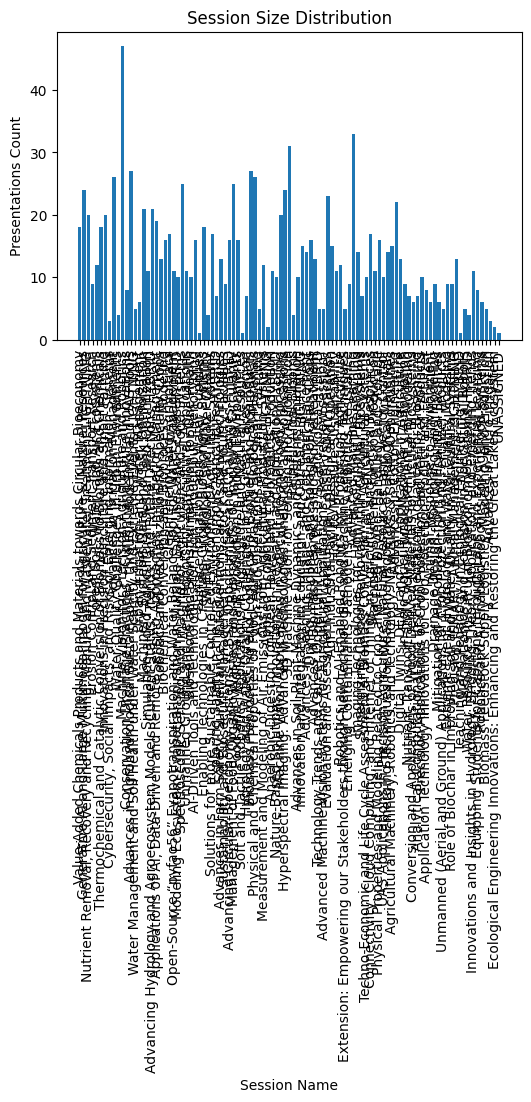

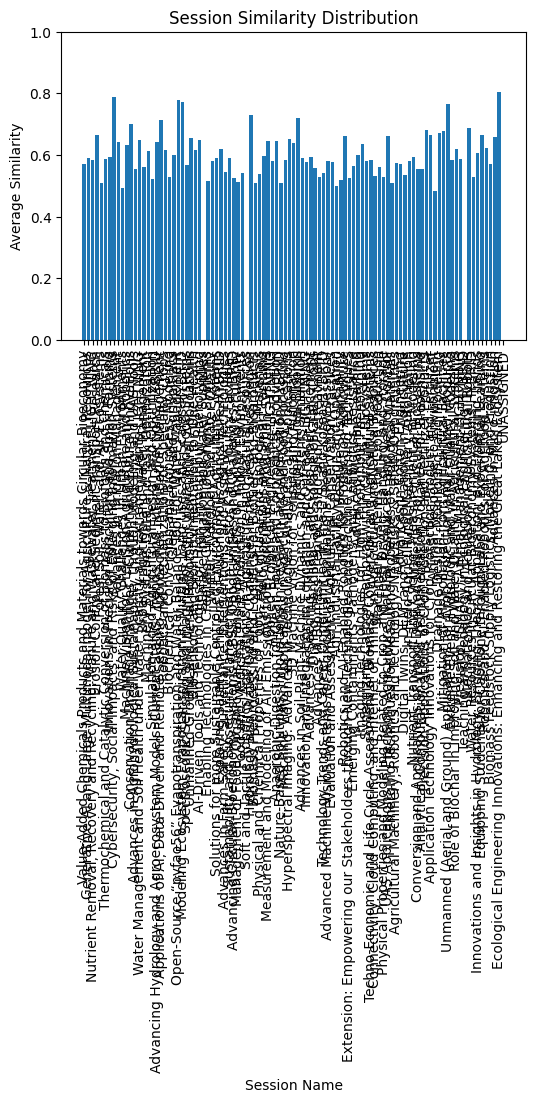

In [24]:

pres_session_similarity, session_similarity = calculate_cluster_similarities(oral_similarities_tensor.cpu().numpy(), np.array(oral_df['Original Session']))
print(f"The average session similarity after submission is {np.mean(list(session_similarity.values()))}")
original_session_list, original_session_dict = create_session_index_lists(oral_df)
original_analysis_results = analyze_sessions(original_session_dict, oral_similarities_tensor.cpu().numpy())
print(f"Average Session Similarity*: {original_analysis_results['avg_similarity']:.3f}")
print(f"Minimum Session Similarity*: {original_analysis_results['min_session_similarity']:.3f}")
print(f"Number of Sessions: {original_analysis_results['num_sessions']}")
print(f"Number of sessions with more than 1 item: {original_analysis_results['clusters_gt1']}")
print(f"Presentations placed in sessions: {sum([len(s) for s in original_session_list])}")
print(f"*Only calculated using sessions with more than 1 item.")
# Plot session sizes
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(original_analysis_results['session_sizes'].keys(), original_analysis_results['session_sizes'].values())
ax.set_ylabel("Presentations Count")
ax.set_xlabel("Session Name")
ax.set_xticks(list(original_analysis_results['session_sizes'].keys()))
ax.set_xticklabels([str(session) for session in original_analysis_results['session_sizes'].keys()], rotation=90)
ax.set_title("Session Size Distribution")
plt.show()

# Plot session similarities
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(original_analysis_results['similarity_values'].keys(), original_analysis_results['similarity_values'].values())
ax.set_ylabel("Average Similarity")
ax.set_ylim(0, 1)
ax.set_xlabel("Session Name")
ax.set_xticks(list(original_analysis_results['similarity_values'].keys()))
ax.set_xticklabels([str(session) for session in original_analysis_results['similarity_values'].keys()], rotation=90)
ax.set_title("Session Similarity Distribution")
plt.show()

The titles are a bit long for publications. Creating a version using letters as a key.

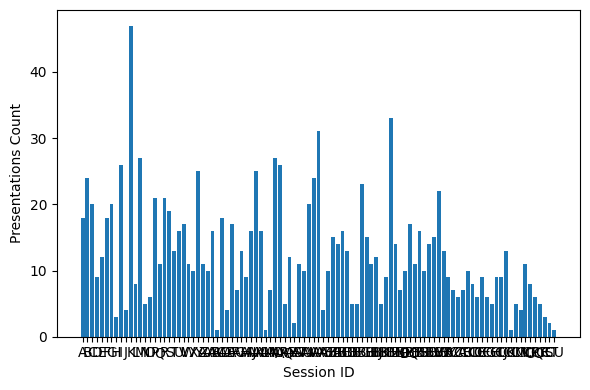

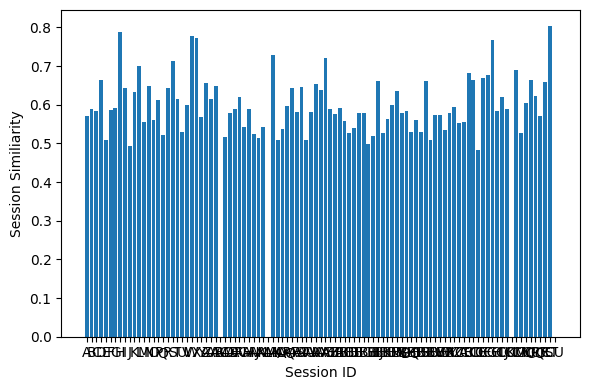

Are labels are the same?: True
The labels:
- **A:** Value-Added Chemicals Products and Materials towards Circular Bioeconomy
- **B:** Generative AI and Large Multimodal model for Agriculture & Natural Resources
- **C:** Nutrient Removal, Recovery and Recycling: Manure and Wastewater Treatment-LIGHTNING
- **D:** Erosion Control and Sediment Transport Research
- **E:** Forest Soil, Water, and Air Ecosystems
- **F:** Thermochemical and Catalytic Conversion of Biomass to Biofuels and Chemicals
- **G:** Innovations in Precision Agriculture and Smart Farming
- **H:** Cybersecurity, Social Impacts, and Risks of Emerging Information Systems
- **I:** Advances in Irrigation Management
- **J:** Water Quality Challenges in Urban Environments
- **K:** Machine Vision for Precision Agriculture and Robotics
- **L:** Conservation Drainage Practices – Current and Future Innovations
- **M:** Advances in Agrohydrological Sustainability through Modeling and UAS Tools
- **N:** Water Management and Soil Heal

In [25]:
import string

orig_session_names = list(original_analysis_results['session_sizes'].keys())
orig_session_sizes = list(original_analysis_results['session_sizes'].values())

def get_alpha_labels(n):
    """Generates alphabetical labels (A, B,..., Z, AA, AB,...)."""
    labels = []
    for i in range(n):
        label = ""
        temp = i
        while temp >= 0:
            remainder = temp % 26
            label = string.ascii_uppercase[remainder] + label
            temp = temp // 26 - 1
            if temp < -1: # Break after processing the last 'digit'
                break
        labels.append(label)
    return labels

orig_short_labels_alpha = get_alpha_labels(len(orig_session_names))

fig_size, ax_size = plt.subplots(figsize=(6, 4))
ax_size.bar(range(len(orig_session_names)), orig_session_sizes) 
ax_size.set_ylabel("Presentations Count")
ax_size.set_xlabel("Session ID") # Update x-axis label
ax_size.set_xticks(range(len(orig_session_names))) 
# Set the tick labels to be the alphabetical labels
ax_size.set_xticklabels(orig_short_labels_alpha) 
fig_size.tight_layout() 
plt.show()

label_mapping_alpha = {label: name for label, name in zip(orig_short_labels_alpha, orig_session_names)}
# for label, name in label_mapping_alpha.items():
#     print(f"- **{label}:** {name}")

orig_session_sim_names = list(original_analysis_results['similarity_values'].keys())
orig_session_sim = list(original_analysis_results['similarity_values'].values())

orig_short_labels_sim_alpha = get_alpha_labels(len(orig_session_sim_names))
# --- Create the Mapping for the Legend ---
label_mapping_alpha_sim = {label: name for label, name in zip(orig_short_labels_sim_alpha, orig_session_sim_names)}
fig_sim, ax_sim = plt.subplots(figsize=(6, 4))
ax_sim.bar(range(len(orig_session_sim_names)), orig_session_sim) 
ax_sim.set_ylabel("Session Similiarity")
ax_sim.set_xlabel("Session ID") # Update x-axis label
ax_sim.set_xticks(range(len(orig_session_sim_names))) 
# Set the tick labels to be the alphabetical labels
ax_sim.set_xticklabels(orig_short_labels_alpha) 
fig_sim.tight_layout() 
plt.show()
# for label, name in label_mapping_alpha_sim.items():
#     print(f"- **{label}:** {name}")

print(f"Are labels are the same?: {label_mapping_alpha == label_mapping_alpha_sim}")
print("The labels:")
for label, name in label_mapping_alpha.items():
    print(f"- **{label}:** {name}")


Presentations within a session should be more similar than the overall average between any two presentations.  How did the sessions created by the traditional process compare to the average between any two presentations?

In [26]:
print("Session Similarity values:")
for value in session_similarity.values():
    print(f"{value:.3f}")
# Calculate how many session similarity values are less than the average similarity
count_below_average = sum(1 for value in session_similarity.values() if value < average_similarity)
print(f"Number of session similarity values below the average similarity: {count_below_average}")

Session Similarity values:
0.637
0.597
0.649
0.600
0.579
0.555
0.527
0.572
0.543
0.643
0.659
0.592
0.589
0.524
0.642
0.498
0.575
0.645
0.554
0.483
0.664
0.713
0.581
0.529
0.570
0.509
0.615
0.598
0.530
0.699
0.553
0.789
0.534
0.670
0.557
0.805
0.562
0.509
0.516
0.664
0.663
0.577
0.620
0.526
0.583
0.541
0.510
0.589
0.721
0.518
0.729
0.652
0.634
0.579
0.577
0.605
0.592
0.582
0.633
0.613
0.561
0.513
0.644
0.689
0.678
0.773
0.508
0.583
0.594
0.778
0.530
0.538
0.588
0.682
0.622
0.660
0.615
0.620
0.521
0.000
0.590
0.568
0.000
0.590
0.579
0.000
0.584
0.541
0.587
0.662
0.000
0.766
0.656
0.561
0.571
0.647
0.493
0.528
0.579
Number of session similarity values below the average similarity: 4


# Linkage Matrix
Create a linkage matrix to visualize the dataset. This linkage matrix will also be used to build the new sessions.
This section creates diagrams of the entire dataset as well as a subset that illustrates challenges with cluster sizes not matching possible session sizes.

Color Threshold: 0.424


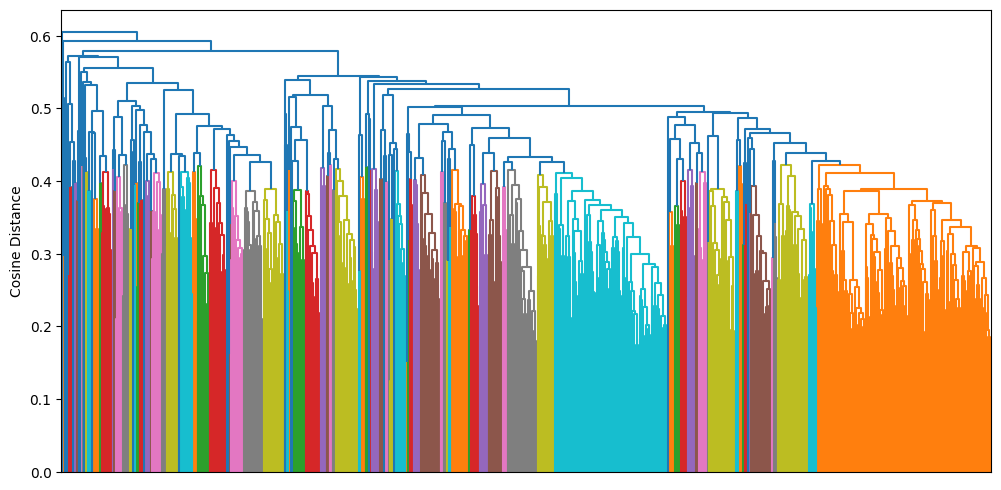

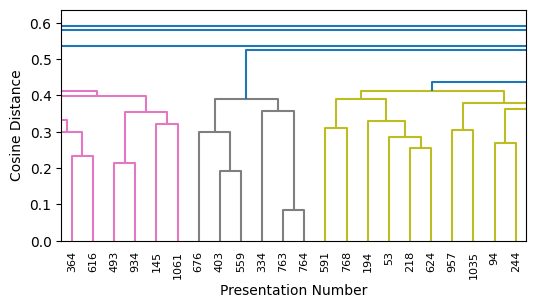

In [27]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
linkage_matrix = linkage(
    y=oral_embeddings_df,
    method='average',
    metric='cosine',
    )
color_threshold = 0.7 * max(linkage_matrix[:, 2])
print(f"Color Threshold: {color_threshold:.3f}")
# All Presentations sorted by count.
fig, ax = plt.subplots(figsize=(12, 6)) 
dn = dendrogram(
    linkage_matrix,
    count_sort='ascending',
    no_labels=True,
    ax=ax,
    )
ax.set_ylabel("Cosine Distance")

# Session cluster size example
fig, ax = plt.subplots(figsize=(6, 3)) 
dn = dendrogram(
    linkage_matrix,
    count_sort='ascending',
    no_labels=False,
    ax=ax,
    )
ax.set_ylabel("Cosine Distance")
ax.set_xlim(1280, 1500)
ax.set_xlabel("Presentation Number")
ax.tick_params(axis='x',labelsize=8)

Text(0, 0.5, 'Cosine Distance')

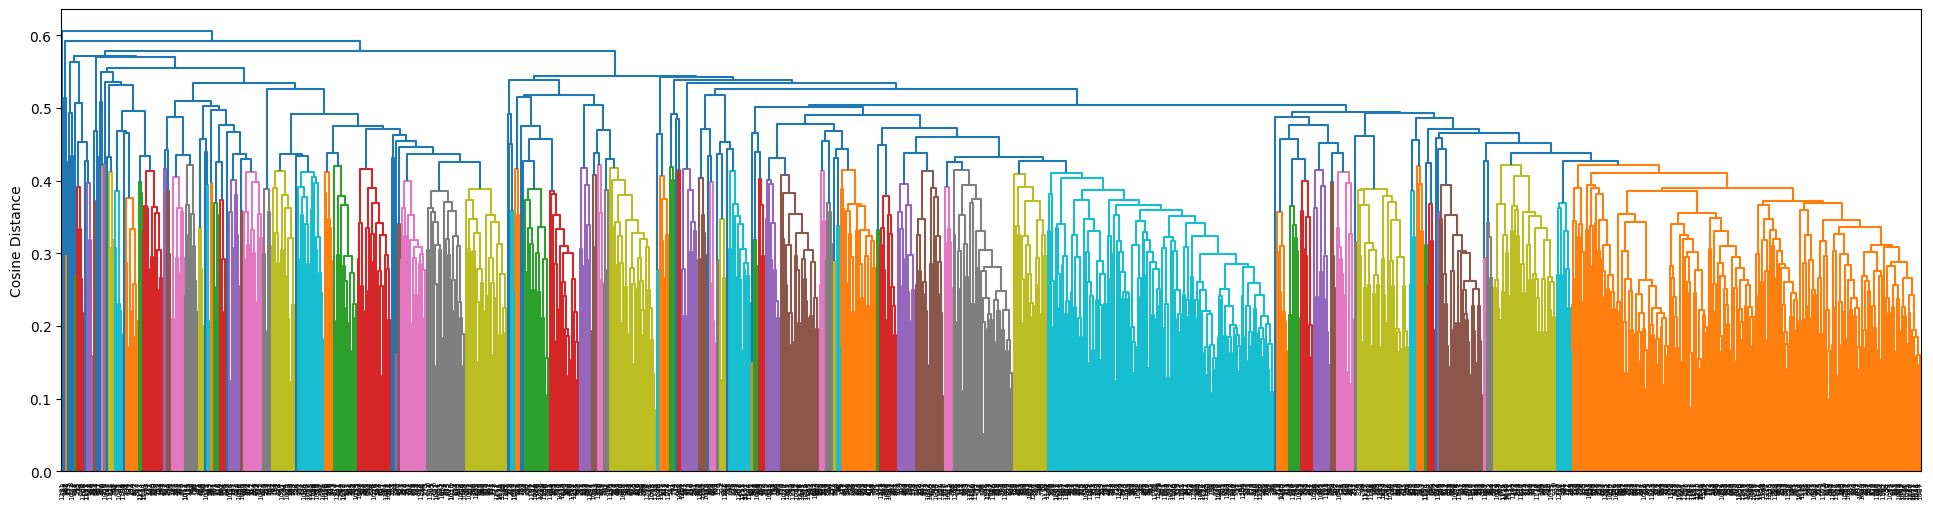

In [28]:
# Plot a very large dendrogram with all presentations labeled
fig, ax = plt.subplots(figsize=(24, 6)) 
dn = dendrogram(
    linkage_matrix,
    count_sort='ascending',
    ax=ax,
    )
ax.set_ylabel("Cosine Distance")

# Create Session Clusters
Session creation occurs using the linkage matrix

In [29]:
# Create sessions using the agglomerative clustering linkage matrix. 
# Start merging with the most similar presentations (top of the linkage matrix).
# Once the clusters are at min_cluster_size, stop automatically merging.

import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def extract_clusters(linkage_matrix, min_cluster_size, n_samples, similarities, tree_merge_stop=1, max_sessions=None):
    """
    Extracts clusters from a linkage matrix, ensuring no cluster is smaller than min_cluster_size.

    Args:
        linkage_matrix: The linkage matrix from scipy.cluster.hierarchy.linkage.
        min_cluster_size: The minimum number of samples in a cluster.
        n_samples: The total number of samples.
        similarities: The similarity matrix tensor.
        tree_merge_stop: The fraction of the tree to stop clustering at.
        max_sessions: Maximum number of sessions to create. If None, there is no limit.

    Returns:
        A list of lists, where each inner list represents a cluster and contains
        the indices of the samples belonging to that cluster.

    """

    final_nodes = []
    final_clusters = []
    unassigned_count = linkage_matrix[:,3].copy() # Number of unassigned clusters. All nodes start unassigned.
    unassigned_leaves = [[] for _ in range(linkage_matrix.shape[0])] # Leaves that have not yet been assigned to a final cluster.
    # Iterate through the linkage matrix (Linkage Matrix (begin -> end) goes bottom -> top on the dendrogram)
    # Process starts with the closest (most similar) nodes/clusters and works its way up the hierarchy.
    # Each row of the linkage matrix represents a merge of two clusters.
    # At each step, check the number of unassigned clusters (unassigned_count) for the two children of the current node.
    # If the number of unassigned clusters for either child is greater than min_cluster_size,
    # then we can create a final cluster (session).
    # If the number of unassigned clusters for both children is less than min_cluster_size,
    # leave them unassigned. Record the unassigned value as the amount remaining unassigned at that node.
    # Continue to the next row of the linkage matrix.

    for i in range(linkage_matrix.shape[0]):
        node_id = n_samples + i
        left_child, right_child = linkage_matrix[i, 0:2].astype(int)
        # Check children to update unassigned_count for this node
        if left_child >= n_samples:
            left_size = unassigned_count[left_child - n_samples]
            unassigned_leaves[i].extend(unassigned_leaves[left_child - n_samples])
        else:
            left_size = 1
            unassigned_leaves[i].append(left_child)
        if right_child >= n_samples:
            right_size = unassigned_count[right_child - n_samples]
            unassigned_leaves[i].extend(unassigned_leaves[right_child - n_samples])
        else:
            right_size = 1
            unassigned_leaves[i].append(right_child)
        unassigned_count[i] = left_size + right_size
        
        # Check if we have a final cluster, 
        # Also, stop making clusters once we are past a certain point in the linkage matrix.
        # Or, stop making clusters once we reach the maximum sessions.
        if unassigned_count[i] > min_cluster_size:
            # Check tree merge stop and max sessions conditions separately
            if i < linkage_matrix.shape[0] * tree_merge_stop:
                # Tree merge stop condition met; Check to make sure we are not at session cap.
                if max_sessions is None or len(final_clusters) < max_sessions:
                    # Under max sessions limit (or no limit)
                    create_cluster = True
                else:
                    create_cluster = False

            if create_cluster:
                # A final cluster has been found. All the presentations (unassigned leaves) in this node are assigned to it.
                final_nodes.append(node_id)
                final_clusters.append(unassigned_leaves[i])
                # Remove all presentations in this node from the unassigned_count.
                # When checked as a child of another node, it will report 0.
                unassigned_count[i] = 0
                unassigned_leaves[i] = []
    # Keep track of the presentations that were assigned in this final step.
    # They are the outliers and should probably be looked at closer.
    forced_merge = unassigned_leaves    
    # Try to merge any unassigned leaves into other clusters.
    # Since we stop merging at a certain point in the linkage matrix, we may have some unassigned leaves left over.
    # These are the leaves that were not assigned to any final cluster.
    # This does not check if the final clusters are too large.
    if unassigned_leaves[-1]:
        for leaf in unassigned_leaves[-1]:
            best_cluster_index = -1
            best_similarity = -1
            for i, cluster in enumerate(final_clusters):
                avg_similarity = similarities[leaf, cluster].mean().item()
                if avg_similarity > best_similarity:
                    best_similarity = avg_similarity
                    best_cluster_index = i
            if best_cluster_index > -1:
                final_clusters[best_cluster_index].append(leaf)
        unassigned_leaves[-1] = []

    return final_clusters, linkage_matrix, forced_merge, final_nodes

In [35]:
def process_clusters(clusters):
    """
    Processes a list of cluster indices to create a cluster dictionary and labels list.

    Args:
        clusters: A list of lists, where each inner list contains the indices
                        of items belonging to a cluster.

    Returns:
        A tuple containing:
            - cluster_dict: A dictionary where keys are cluster IDs (integers) and
                          values are lists of item indices belonging to that cluster.
            - labels: A list (or Pandas Series) where each element at index i
                      represents the cluster assignment of item i.
    """
    # Find the maximum index value across all clusters
    max_index = 0
    for cluster in clusters:
        if cluster and max(cluster) > max_index:
            max_index = max(cluster)
    
    # Initialize labels list with None values of appropriate size
    labels = [None] * (max_index + 1)  # +1 because indices are 0-based

    cluster_dict = {}
    for cluster_id, cluster_indices in enumerate(clusters):
        cluster_dict[cluster_id] = cluster_indices
        for item_index in cluster_indices:
            labels[item_index] = cluster_id  # Assign cluster ID to the item index

    return cluster_dict, labels


For AIM 2025, there were 100 oral sessions that could accept presentations from the Call for Papers.

For session creation, the number of sessions to create (100) ends up determining when the process stops creating new sessions. Based on prior experiments, if the number of sessions is not defined, it would be important to set a percentage of the tree at which to stop merging sessions. This is set to 95% based on this experimentation. If the process runs all the way to the top of the tree, it ends up forcing the merging of very different presentations. It is general better just to use these to fill in other sessions than to merge them into their own session.

In [41]:
min_cluster_size = 8
tree_merge_stop = 1
max_num_sessions = 100
session_indices, link_mat_final, outliers_merged, fnode_final = extract_clusters(linkage_matrix, 
                                                                                min_cluster_size, 
                                                                                n_samples=len(oral_similarities_tensor), 
                                                                                similarities=oral_similarities_tensor, 
                                                                                tree_merge_stop=tree_merge_stop, 
                                                                                max_sessions=max_num_sessions
                                                                                )

cluster_dict, labels = process_clusters(session_indices)
analysis_results_after_cluster = analyze_sessions(cluster_dict, oral_similarities_tensor.cpu().numpy())
print(f"Tree Merge Stop: {tree_merge_stop}")
print(f"Average Session Similarity: {analysis_results_after_cluster['avg_similarity']:.3f}")
print(f"Minimum Session Similarity: {analysis_results_after_cluster['min_session_similarity']:.3f}")
print(f"Number of Sessions: {analysis_results_after_cluster['num_sessions']}")
print(f"Number of sessions with more than 1 item: {analysis_results_after_cluster['clusters_gt1']}")
print(f"Presentations placed in sessions: {sum([len(s) for s in session_indices])}")


Tree Merge Stop: 1
Average Session Similarity: 0.657
Minimum Session Similarity: 0.557
Number of Sessions: 100
Number of sessions with more than 1 item: 100
Presentations placed in sessions: 1239


### Save Session Number from Clustering to Presentation Dataframe

In [42]:
cluster_dict, labels = process_clusters(session_indices)
# Replace None values in the labels list with a default integer value (e.g., -1)
labels = [label if label is not None else -1 for label in labels]

# Assign the labels to the DataFrame and explicitly set the data type to int
oral_df['Clustering Session'] = pd.Series(labels, dtype='int')
# oral_df['Clustering Session'] = pd.Series(labels)
oral_df.to_pickle('aim2025_clustered_presentations.pkl')
oral_df.to_csv('AIM25 Clustering Sessioned Presentations.csv', index=True)

## Export for Web App

In [43]:
import pandas as pd
# oral_df = pd.read_pickle('aim2025_clustered_presentations.pkl')
oral_no_abstracts_df = oral_df.drop(columns=['Title and Abstract','Abstract'])
oral_no_abstracts_df.to_pickle('aim2025_clustered_presentations_no_abstracts.pkl')

In [44]:
cluster_session_list, cluster_session_dict = create_session_index_lists(oral_df, session_column='Clustering Session')

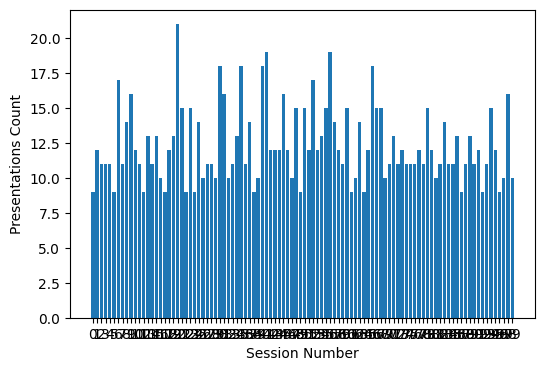

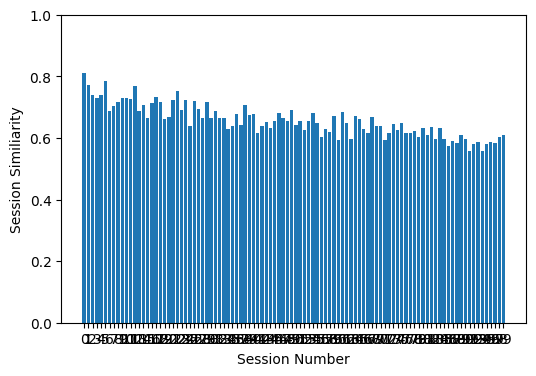

In [45]:
# Plot session size by session number - Repeated for copying into publications.
# st.subheader("Session Size Distribution - Clustered Sessions") 
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(analysis_results_after_cluster['session_sizes'].keys(), analysis_results_after_cluster['session_sizes'].values())
ax.set_ylabel("Presentations Count")
ax.set_xlabel("Session Number")
ax.set_xticks(list(analysis_results_after_cluster['session_sizes'].keys()))
ax.set_xticklabels([str(session) for session in analysis_results_after_cluster['session_sizes'].keys()])
plt.show()

# Plot session similarities
# st.subheader("Session Similarity Distribution - Clustered Sessions") 
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(analysis_results_after_cluster['similarity_values'].keys(), analysis_results_after_cluster['similarity_values'].values())
ax.set_ylabel("Session Similiarity")
ax.set_ylim(0, 1)
ax.set_xlabel("Session Number")
ax.set_xticks(list(analysis_results_after_cluster['similarity_values'].keys()))
ax.set_xticklabels([str(session) for session in analysis_results_after_cluster['similarity_values'].keys()])
plt.show()

# Creating Session Names and Keywords

In [ ]:
# This code can be used to load the clustered presentations if processing starts at this point.
import pandas as pd
# Load the DataFrame from the pickle file
oral_df = pd.read_pickle('aim2025_clustered_presentations.pkl')
oral_df['Clustering Session'] = oral_df['Clustering Session'].astype(int)  # Convert to integer type
import numpy as np
cluster_labels = oral_df['Clustering Session'].unique()
# Create a dict for the cluster indices
cluster_dict = oral_df.groupby('Clustering Session').indices
# Convert keys to integers because Pandas creates them as different types.
cluster_dict = {int(k): np.array(v, dtype=np.int64).tolist() for k, v in cluster_dict.items()}

In [47]:
sessions_dict = {}
for session_num, presentation_indices in cluster_dict.items():
    sessions_dict[session_num] = {"Indices": presentation_indices, "Presentations": []}
    for index in presentation_indices:
        try:
            title_abstract = oral_df.loc[index, "Title and Abstract"]
            sessions_dict[session_num]["Presentations"].append(title_abstract)
        except KeyError:
            print(f"Warning: Index {index} not found in oral_df for session {session_num}. Skipping.")
            continue # Skip the index if it's not present in the dataframe

## Gemini
### Full Example Titles and Keywords

In [48]:
import time

import os
from google import genai
from google.genai import types
from pydantic import BaseModel

# Support env variables from .env file if defined
import os
from dotenv import load_dotenv
env_path = load_dotenv('.env')
load_dotenv(env_path)

class Session_info(BaseModel):
    title_1: str
    title_2: str
    title_3: str
    keywords: str

start_time = time.time()
# Create the client
client = genai.Client(api_key=os.environ["GEMINI_API_KEY"])
# Create titles
for session_key, session_value in sessions_dict.items():
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents=("I am organizing oral research presentation sessions for the American Society of Biological and Agricultural Engineers"
                "Annual International Meeting. Please provide 3 options for the name/title of a session. "
                    "Also provide 5 keywords describing the session. The name and keywords should highlight the commonality among all presentations. "
                    "The target audience for titles and keywords is engineering designers and researchers."
                    "The title should be descriptive of the content and be interesting and engaging. \n"
                    "Please respond in this format\n\n "
                    "{"
                    "     'title_1': 'Robotic Vision and Actuation: Advancing Precision Weed Management in Agriculture',\n"
                    "     'title_2': 'AI-Driven Weed Control: From Smart Sprayers to Autonomous Robotics',\n"
                    "     'title_3': 'Next-Generation Weed Management: Integrating Deep Learning, Robotics, and Advanced Sensing',\n"
                    "     'keywords': 'Robotics, Machine Vision, Precision Agriculture, Weed Control, Artificial Intelligence'    }\n\n"
                    "The titles and abstracts for presentations assigned to this session are:\n"
                    + str(session_value['Presentations'])
                    ),
            config={ # Constraint response to a specific schema
            'response_mime_type': 'application/json',
            'response_schema': Session_info,
        },

    )
    print(response.text)
    titles = response.text
    # Use instantiated objects.
    my_sessions: Session_info = response.parsed
    print(my_sessions)

    session_value['Gemini Ex Title 1'] = my_sessions.title_1
    session_value['Gemini Ex Title 2'] = my_sessions.title_2
    session_value['Gemini Ex Title 3'] = my_sessions.title_3
    session_value['Gemini Ex Keywords'] = my_sessions.keywords
end_time = time.time()
gemini_elapsed_time = end_time - start_time
print(f"Processing time: {gemini_elapsed_time:.4f} seconds")


{
    "title_1": "Optimizing Irrigation: Machine Learning and Remote Sensing for Soil Moisture Management",
    "title_2": "Sensing and Modeling Soil Moisture: Advancing Precision Irrigation Strategies",
    "title_3": "Data-Driven Irrigation: Integrating Soil Moisture Monitoring, Machine Learning, and Remote Sensing",
    "keywords": "Soil Moisture, Machine Learning, Remote Sensing, Irrigation Management, Precision Agriculture"
}
title_1='Optimizing Irrigation: Machine Learning and Remote Sensing for Soil Moisture Management' title_2='Sensing and Modeling Soil Moisture: Advancing Precision Irrigation Strategies' title_3='Data-Driven Irrigation: Integrating Soil Moisture Monitoring, Machine Learning, and Remote Sensing' keywords='Soil Moisture, Machine Learning, Remote Sensing, Irrigation Management, Precision Agriculture'
{
  "title_1": "Optimizing Irrigation: Modeling, Scheduling, and Decision Support Systems",
  "title_2": "Advancements in Irrigation Management: Tools and Techniques

### Minimal Examples
Include the response form, but don't provide actual examples.

In [49]:
import time

import os
from google import genai
from google.genai import types
from pydantic import BaseModel

# Support env variables from .env file if defined
import os
from dotenv import load_dotenv
env_path = load_dotenv('.env')
load_dotenv(env_path)

class Session_info(BaseModel):
    title_1: str
    title_2: str
    title_3: str
    keywords: str

start_time = time.time()
# Create the client
client = genai.Client(api_key=os.environ["GEMINI_API_KEY"])
# Create titles
for session_key, session_value in sessions_dict.items():
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents=("I am organizing oral research presentation sessions for the American Society of Biological and Agricultural Engineers"
                "Annual International Meeting. Please provide 3 options for the name/title of a session. "
                    "Also provide 5 keywords describing the session. The name and keywords should highlight the commonality among all presentations. "
                    "The target audience for titles and keywords is engineering designers and researchers."
                    "The title should be descriptive of the content and be interesting and engaging. \n"
                    "Please respond in this format\n\n "
                    "{"
                    "     'title_1': 'Session Title',\n"
                    "     'title_2': 'Session Title',\n"
                    "     'title_3': 'Session Title',\n"
                    "     'keywords': 'keyword1, keyword2, keyword3, keyword4, keyword5'    }\n\n"
                    "The titles and abstracts for presentations assigned to this session are:\n"
                    + str(session_value['Presentations'])
                    ),
            config={ # Constraint response to a specific schema
            'response_mime_type': 'application/json',
            'response_schema': Session_info,
        },

    )
    print(response.text)
    titles = response.text
    # Use instantiated objects.
    my_sessions: Session_info = response.parsed
    print(my_sessions)

    session_value['Gemini MinEx Title 1'] = my_sessions.title_1
    session_value['Gemini MinEx Title 2'] = my_sessions.title_2
    session_value['Gemini MinEx Title 3'] = my_sessions.title_3
    session_value['Gemini MinEx Keywords'] = my_sessions.keywords
end_time = time.time()
gemini_elapsed_time = end_time - start_time
print(f"Processing time: {gemini_elapsed_time:.4f} seconds")


{
    "title_1": "Data-Driven Soil Moisture Modeling for Precision Irrigation",
    "title_2": "Advancing Irrigation Management: Machine Learning and Remote Sensing of Soil Moisture",
    "title_3": "Optimizing Water Use: Predictive Modeling of Soil Moisture Dynamics",
    "keywords": "soil moisture, machine learning, irrigation management, remote sensing, precision agriculture"
}
title_1='Data-Driven Soil Moisture Modeling for Precision Irrigation' title_2='Advancing Irrigation Management: Machine Learning and Remote Sensing of Soil Moisture' title_3='Optimizing Water Use: Predictive Modeling of Soil Moisture Dynamics' keywords='soil moisture, machine learning, irrigation management, remote sensing, precision agriculture'
{
    "title_1": "Advancements in Irrigation Scheduling: Models, Tools, and Applications",
    "title_2": "Precision Irrigation: Optimizing Water Use with Innovative Technologies",
    "title_3": "ET Modeling and Decision Support Systems for Sustainable Irrigation",


### No Example
Do not provide a response form example at all. Just rely on the prompt controls.

In [50]:
import time

import os
from google import genai
from google.genai import types
from pydantic import BaseModel

# Support env variables from .env file if defined
import os
from dotenv import load_dotenv
env_path = load_dotenv('.env')
load_dotenv(env_path)

class Session_info(BaseModel):
    title_1: str
    title_2: str
    title_3: str
    keywords: str

start_time = time.time()
# Create the client
client = genai.Client(api_key=os.environ["GEMINI_API_KEY"])
# Create titles
for session_key, session_value in sessions_dict.items():
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents=("I am organizing oral research presentation sessions for the American Society of Biological and Agricultural Engineers"
                "Annual International Meeting. Please provide 3 options for the name/title of a session. "
                    "Also provide 5 keywords describing the session. The name and keywords should highlight the commonality among all presentations. "
                    "The target audience for titles and keywords is engineering designers and researchers."
                    "The title should be descriptive of the content and be interesting and engaging. \n"
                    "The titles and abstracts for presentations assigned to this session are:\n"
                    + str(session_value['Presentations'])
                    ),
            config={ # Constraint response to a specific schema
            'response_mime_type': 'application/json',
            'response_schema': Session_info,
        },

    )
    print(response.text)
    titles = response.text
    # Use instantiated objects.
    my_sessions: Session_info = response.parsed
    print(my_sessions)

    session_value['Gemini NoEx Title 1'] = my_sessions.title_1
    session_value['Gemini NoEx Title 2'] = my_sessions.title_2
    session_value['Gemini NoEx Title 3'] = my_sessions.title_3
    session_value['Gemini NoEx Keywords'] = my_sessions.keywords
end_time = time.time()
gemini_elapsed_time = end_time - start_time
print(f"Processing time: {gemini_elapsed_time:.4f} seconds")


{
  "title_1": "Data-Driven Approaches for Precision Irrigation: Modeling and Management",
  "title_2": "Machine Learning and Remote Sensing for Optimizing Soil Moisture and Irrigation",
  "title_3": "Advancements in Soil Moisture Modeling for Enhanced Irrigation Management",
  "keywords": "soil moisture, irrigation management, machine learning, remote sensing, precision agriculture"
}
title_1='Data-Driven Approaches for Precision Irrigation: Modeling and Management' title_2='Machine Learning and Remote Sensing for Optimizing Soil Moisture and Irrigation' title_3='Advancements in Soil Moisture Modeling for Enhanced Irrigation Management' keywords='soil moisture, irrigation management, machine learning, remote sensing, precision agriculture'
{
  "title_1": "Advancements in Evapotranspiration Modeling and Irrigation Scheduling Tools",
  "title_2": "Optimizing Irrigation: Innovative Tools and Techniques for Water Management",
  "title_3": "Data-Driven Approaches for Sustainable Irrigation

### Save the Gemini Results

In [52]:
df_sessions = pd.DataFrame.from_dict(sessions_dict, orient='index')
df_sessions.to_csv('Gemini_sessionsAIM25.csv', index=True)
import pickle
df_sessions.to_pickle('AI_sessionsAIM25.pkl')
with open("AI_sessions_dictAIM25.pkl", "wb") as f:
    pickle.dump(sessions_dict, f) 
